In [1]:
import numpy as np
import matplotlib.pyplot as plt
try:
    from sklearn.datasets.samples_generator import make_blobs
except:
    from sklearn.datasets import make_blobs

%matplotlib inline

/Users/longchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


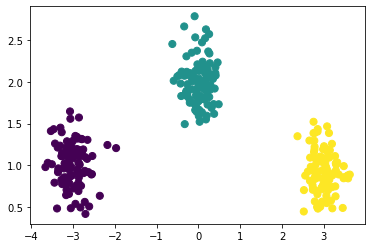

In [7]:
# Create the  training data
np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

# One VS All

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class OneVsAllClassifier(BaseEstimator, ClassifierMixin):  
    def __init__(self, estimator, n_classes):      
        self.n_classes = n_classes 
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False

    def fit(self, X, y=None):
        for i in range(self.n_classes):
            y_cur = (y == i).astype(int)
            self.estimators[i].fit(X, y_cur)
        
        self.fitted = True  
        return self   

    def decision_function(self, X):
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError(
                "Base estimator doesn't have a decision_function attribute.")
        
        res = np.zeros((X.shape[0], self.n_classes))
        for i in range(self.n_classes):
            res[:, i] = self.estimators[i].decision_function(X)
        
        return res
    
    def predict(self, X):
        return self.decision_function(X).argmax(axis=1)

Coeffs 0
[[-1.05854163 -0.90295959]]
Coeffs 1
[[-0.27439972  0.45755914]]
Coeffs 2
[[ 0.89164476 -0.82601248]]


/Users/longchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


array([[ 99,   1,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

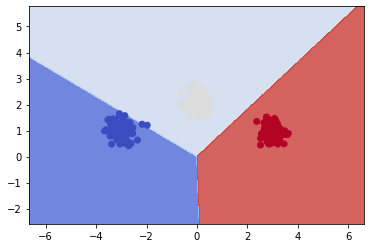

In [20]:
#Here we test the OneVsAllClassifier
from sklearn import svm
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=200)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X,y)

for i in range(3) :
    print("Coeffs %d"%i)
    print(clf_onevsall.estimators[i].coef_) #Will fail if you haven't implemented fit yet

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.savefig('Q6.png')

from sklearn import metrics
metrics.confusion_matrix(y, clf_onevsall.predict(X))

# Multiclass SVM

In [58]:
def zeroOne(y,a) :
    '''
    Computes the zero-one loss.
    @param y: output class
    @param a: predicted class
    @return 1 if different, 0 if same
    '''
    return int(y != a)

def featureMap(X,y,num_classes) :
    '''
    Computes the class-sensitive features.
    @param X: array-like, shape = [n_samples,n_inFeatures] or [n_inFeatures,], input features for input data
    @param y: a target class (in range 0,..,num_classes-1)
    @return array-like, shape = [n_samples,n_outFeatures], the class sensitive features for class y
    '''
    num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) == 1 else (X.shape[0],X.shape[1])
    n_outFeatures = num_inFeatures * num_classes
    
    # corner case: when we only have one datapoint
    if num_samples == 1:
        try:
            y = y[0]
        except:
            y = y
        res = np.zeros(n_outFeatures)
        res[y * num_inFeatures : y * num_inFeatures + num_inFeatures] = X
        return res

    res = np.zeros((num_samples, n_outFeatures))

    for idx, xi in enumerate(X):
        temp = np.zeros(n_outFeatures)
        temp[y[idx] * num_inFeatures : y[idx] * num_inFeatures + num_inFeatures] = xi
        res[idx] = temp
    
    return res

def sgd(X, y, num_outFeatures, subgd, eta = 0.1, T = 10000):
    '''
    Runs subgradient descent, and outputs resulting parameter vector.
    @param X: array-like, shape = [n_samples,n_features], input training data 
    @param y: array-like, shape = [n_samples,], class labels
    @param num_outFeatures: number of class-sensitive features
    @param subgd: function taking x,y,w and giving subgradient of objective
    @param eta: learning rate for SGD
    @param T: maximum number of iterations
    @return: vector of weights
    '''
    num_samples = X.shape[0]
    w = np.zeros(num_outFeatures)
    
    for cur_epoch in range(T):
        cur_idx = np.random.choice(num_samples, 1)
        # update
        w = w - eta * subgd(X[cur_idx], y[cur_idx], w)
    
    return w

class MulticlassSVM(BaseEstimator, ClassifierMixin):
    '''
    Implements a Multiclass SVM estimator.
    '''
    def __init__(self, num_outFeatures, lam=1.0, num_classes=3, Delta=zeroOne, Psi=featureMap):       
        '''
        Creates a MulticlassSVM estimator.
        @param num_outFeatures: number of class-sensitive features produced by Psi
        @param lam: l2 regularization parameter
        @param num_classes: number of classes (assumed numbered 0,..,num_classes-1)
        @param Delta: class-sensitive loss function taking two arguments (i.e., target margin)
        @param Psi: class-sensitive feature map taking two arguments
        '''
        self.num_outFeatures = num_outFeatures
        self.lam = lam
        self.num_classes = num_classes
        self.Delta = Delta
        self.Psi = lambda X,y : Psi(X,y,num_classes)
        self.fitted = False
    
    def subgradient(self,x,y,w):
        '''
        Computes the subgradient at a given data point x,y
        @param x: sample input
        @param y: sample class
        @param w: parameter vector
        @return returns subgradient vector at given x,y,w
        '''
        res = []
        
        # compute class weights
        for y_prime in range(self.num_classes):
            res.append(self.Delta(y, y_prime) + np.dot(w, self.Psi(x, y_prime) - self.Psi(x, y)))
        
        # get argmax
        y_hat = np.argmax(res)
        
        return 2 * self.lam * w + self.Psi(x, y_hat) - self.Psi(x, y)
        
    def fit(self,X,y,eta=0.1,T=10000):
        '''
        Fits multiclass SVM
        @param X: array-like, shape = [num_samples,num_inFeatures], input data
        @param y: array-like, shape = [num_samples,], input classes
        @param eta: learning rate for SGD
        @param T: maximum number of iterations
        @return returns self
        '''
        self.coef_ = sgd(X,y,self.num_outFeatures,self.subgradient,eta,T)
        self.fitted = True
        return self
    
    def decision_function(self, X):
        '''
        Returns the score on each input for each class. Assumes
        that fit has been called.
        @param X : array-like, shape = [n_samples, n_inFeatures]
        @return array-like, shape = [n_samples, n_classes] giving scores for each sample,class pairing
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        res = np.zeros((X.shape[0], self.num_classes))
        
        # calculate scores for each classes
        for idx, xi in enumerate(X):
            res[idx, :] = [np.dot(self.coef_, self.Psi(xi, yi)) for yi in range(self.num_classes)]
        
        return res
            
    def predict(self, X):
        '''
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples, n_inFeatures], input data to predict
        @return array-like, shape = [n_samples,], class labels predicted for each data point
        '''

        #Your code goes here and replaces following return statement
        return self.decision_function(X).argmax(axis=1)

w:
[-0.28795216 -0.01585814 -0.06504174  0.07972175  0.3529939  -0.06386361]


array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

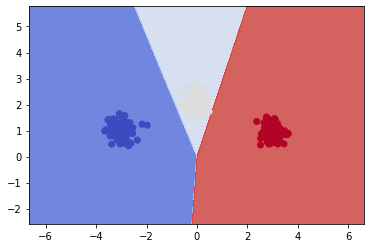

In [67]:
#the following code tests the MulticlassSVM and sgd
#will fail if MulticlassSVM is not implemented yet
est = MulticlassSVM(6,lam=1)
est.fit(X,y,eta=0.01)
print("w:")
print(est.coef_)
Z = est.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.savefig('Q10.png')


from sklearn import metrics
metrics.confusion_matrix(y, est.predict(X))